In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from code.company_data_pipeline import get_company_description_df_and_feature_names
from code.ticker_data_pipeline import get_ticker_price_df_from_file, diff_df
from code.model import Model

%matplotlib inline

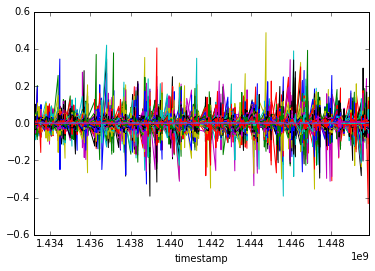

In [2]:
# This function loads ticker data from the file, cleans it, and returns it as a pandas data frame
# It is slow.
ticker_df = get_ticker_price_df_from_file()

# Takes the percent change and does some other cleaning
dif_df = diff_df(ticker_df)
dif_df.plot(legend=False)

In [3]:
dif_df.columns

Index([u'aaap', u'aal', u'aaoi', u'aaon', u'aapc', u'aapl', u'aaww', u'abax',
       u'abcb', u'abco',
       ...
       u'zbra', u'zg', u'zgnx', u'zion', u'ziop', u'zltq', u'zsph', u'zumz',
       u'zvzzt', u'zxyz-a'],
      dtype='object', length=1706)

In [4]:
company_df, feature_names = get_company_description_df_and_feature_names()
company_df.head()

,description,tfidf
ticker,,
aaap,We are an innovative radiopharmaceutical compa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aal,"American Airlines Group Inc. (AAG), a Delaware...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aame,"Atlantic American Corporation, a Georgia corpo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aaoi,This report contains forward-looking statement...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aaon,"AAON, Inc., a Nevada corporation, (""AAON Nevad...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [5]:
m = Model(company_df, feature_names)
m.fit(dif_df)

/Users/Brian/anaconda/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':


In [6]:
def analyze_principle_component(component, component_labels, company_df, vocab,
                                n_companies=15, n_words=20):
    '''
    component: 1d numpy array representing a linear combination of companies
    component_labels: the ticker symbols of the companies from component
    company_df: pandas dataframe with index ticker symbols, a column 'description' with a
                text description of the company and a column 'tfidf' a tfidf vector
    vocab: the vocab for the tfidf vector above
    
    returns: A dictionary with the following information about the company:
                'companies_pro': Numpy array of ticker symbols of the top n_companies
                                 companies associated with this component
                'importances_pro': Numpy array of floats that tell the weight of the
                                   above companies in the principle component
                'companies_con': Numpy array of ticker symbols of the top n_companies
                                 companies anti-correlated with this component
                'importances_con': Numpy array of floats that tell the weight of the
                                   above companies in the principle component 
                                   (these numbers are positive, measuring the anti-correlation)
                'words_pro':
                'word_importances_pro':
    '''
    d = {}
    idx_con = np.argsort(component)[:n_companies]
    d['companies_con'] = component_labels[idx_con]
    d['importances_con'] = component[idx_con] * -1.
    
    idx_pro = np.argsort(component)[::-1][:n_companies]
    d['companies_pro'] = component_labels[idx_pro]
    d['importances_pro'] = component[idx_pro]
    
    # TODO: Weight the word importances by the company importance
    #word_importances_list_con = company_df.ix[d['companies_con'], :]['tfidf']
    #print word_importances_list_con
    
    
    
    word_importances_con = company_df.ix[d['companies_con'], :]['tfidf'].mean()
    word_idx_con = word_importances_con.argsort()[::-1][:n_words]
    d['words_con'] = np.array(vocab)[word_idx_con]
    d['word_importances_con'] = word_importances_con[word_idx_con]
    
    word_importances_pro = company_df.ix[d['companies_pro'], :]['tfidf'].mean()
    word_idx_pro = word_importances_pro.argsort()[::-1][:n_words]
    d['words_pro'] = np.array(vocab)[word_idx_pro]
    d['word_importances_pro'] = word_importances_pro[word_idx_pro]
    
    return d

In [7]:
def draw_importances_graph(names, importances, title, ax):
    n = len(names)
    #ax.figure()
    ax.set_title(title, fontdict={'fontsize': 10})
    ax.bar(range(n), importances,
           color="r", align="center")
    ax.set_xticks(range(n))
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_xlim([-1, n])
    labels = ax.get_xticks()
    ax.tick_params(labelsize=20)

In [8]:
def graph_component(d):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 18))
    f.subplots_adjust(bottom=0.01)

    draw_importances_graph(d['companies_con'],
                           d['importances_con'], 
                           "Company Importances Con",
                           ax1)

    draw_importances_graph(d['words_con'],
                           d['word_importances_con'], 
                           "Word Importances Con",
                           ax2)

    draw_importances_graph(d['companies_pro'],
                           d['importances_pro'], 
                           "Company Importances Pro",
                           ax3)

    draw_importances_graph(d['words_pro'],
                           d['word_importances_pro'], 
                           "Word Importances Pro",
                           ax4)


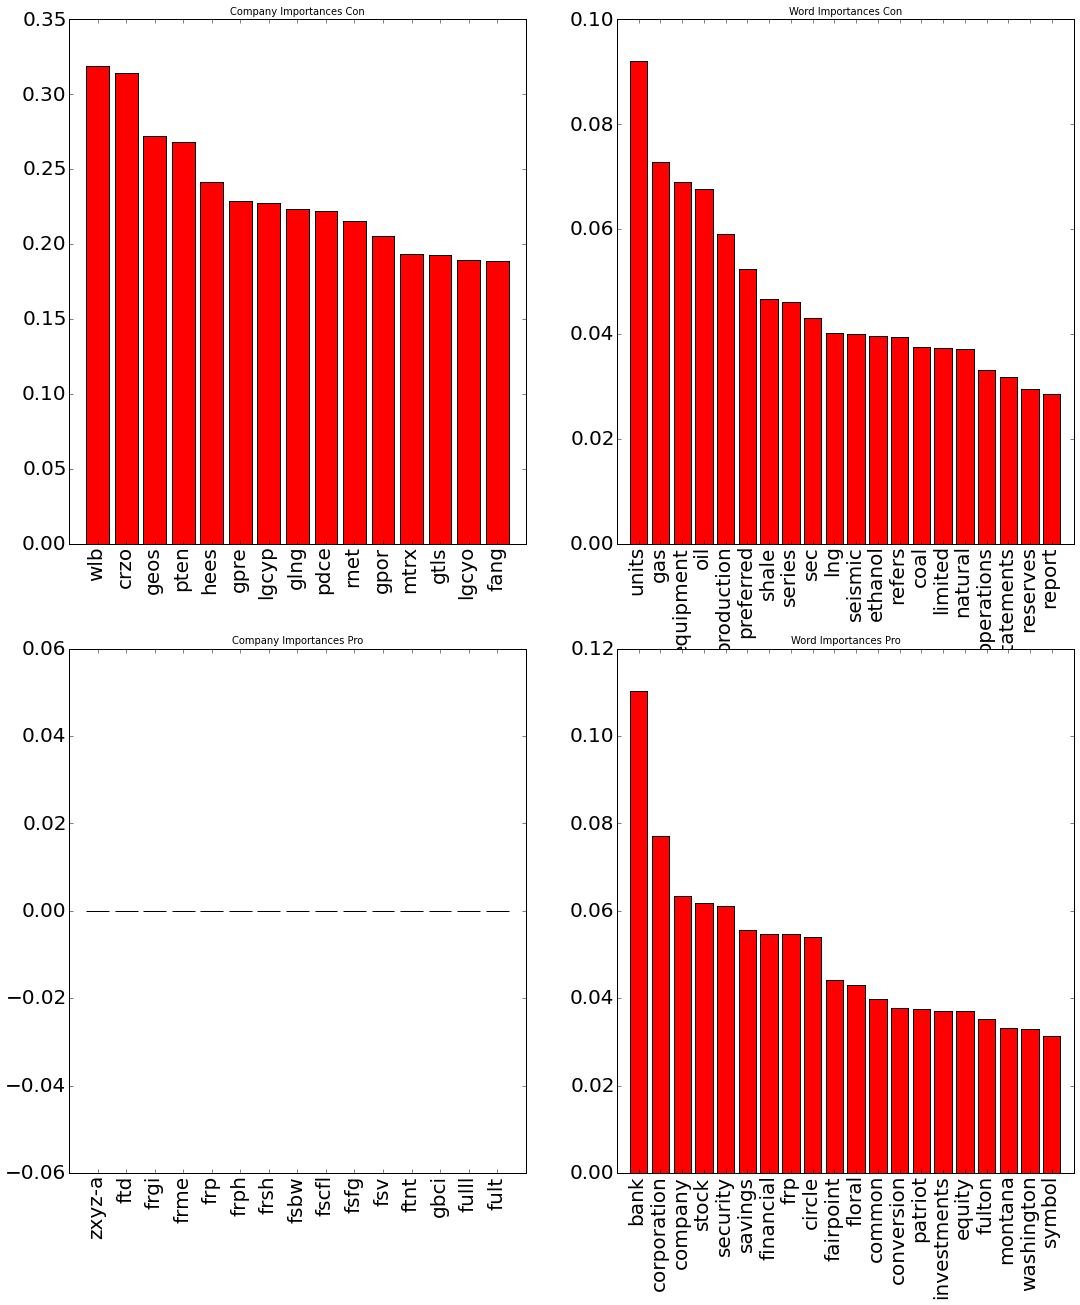

In [9]:
d = m.analyze_principle_component(3)
graph_component(d)

# one graph with all companies

In [10]:
# We can clean up the data and get better results by finding a way to dedupe the list of
# companies.  Some are subsidiaries of the others and track very closely.  These are then 
# overrepresented in the data.

In [12]:
# We could try daily instead of hourly.  

In [13]:
# TODO: Weight the tfidf average by company importance.  